# Capturando batimentos cardiacos

In [1]:
import pandas as pd
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import os
from os.path import join, dirname
from dotenv import load_dotenv

dotenv_path = join(dirname('__file__'), '.env')

load_dotenv(dotenv_path)

RAW_DATA = os.environ.get("RAW_DATA")
ROOT_PATH = os.environ.get("ROOT_PATH")


In [3]:
path = f"{ROOT_PATH}{RAW_DATA}EKG/"
infos = pd.read_json(f"{ROOT_PATH}docs/siena_infos.json")


In [4]:
infos

,name,registration_start,registration_end,seizure_start,seizure_end,total,seizure_start_sec,seizure_end_sec,total_seizure,highpass,lowpass,meas_date,sfreq,ch_names,nchan
0,PN00-1.edf,19.39.33,20.22.58,19.58.36,19.59.46,2605,1392,1462,70,1.591549,30,2016-01-01,512,"[EEG Fp1, EEG F3, EEG C3, EEG P3, EEG O1, EEG ...",35
1,PN00-2.edf,02.18.17,02.56.19,02.38.37,02.39.31,2282,1008,1062,54,1.591549,30,2016-01-01,512,"[EEG Fp1, EEG F3, EEG C3, EEG P3, EEG O1, EEG ...",35
2,PN00-3.edf,18.15.44,18.57.13,18.28.29,18.29.29,2489,1664,1724,60,1.591549,30,2016-01-01,512,"[EEG Fp1, EEG F3, EEG C3, EEG P3, EEG O1, EEG ...",35
3,PN00-4.edf,20.51.43,21.26.25,21.08.29,21.09.43,2082,1002,1076,74,1.591549,30,2016-01-01,512,"[EEG Fp1, EEG F3, EEG C3, EEG P3, EEG O1, EEG ...",35
4,PN00-5.edf,22.22.04,22.57.27,22.37.08,22.38.15,2123,1152,1219,67,5.305165,30,2016-01-01,512,"[EEG Fp1, EEG F3, EEG C3, EEG P3, EEG O1, EEG ...",35


In [506]:
info = dict(infos.iloc[4])


In [507]:
file = f"{path}{info['name'].replace('edf','parquet')}"

df = pd.read_parquet(file)


In [508]:
seizure_start_sec = info["seizure_start_sec"]
seizure_end_sec = info["seizure_end_sec"]
total_seizure = info["total_seizure"]
fs = int(info["sfreq"])


In [509]:
com_crise = df[df['window'].between(
    seizure_start_sec, seizure_end_sec)]['EKG_EKG'].to_numpy()


PS: seguimentos sem crise são amostras presentes em um intevalo de tempo igual ao de crise, presentes 60 segundos antes do inicio de crise

In [510]:
sem_crise = df[df['window'].between(
    seizure_start_sec - (total_seizure + 60), seizure_start_sec-60)]['EKG_EKG'].to_numpy()


## Plotando e salvando imagens

In [511]:
from pandas import DataFrame
from matplotlib.axes._subplots import Axes

def beats_plot(ax: Axes, signals: list, mean_signals: DataFrame,  label: str):

    cont = 0

    for key in signals:
        if cont == 0:
            line_legend = 'Batimentos'
        else:
            line_legend = None
        ax.plot(key, color='gray', label=line_legend)
        cont+=1

    mean_signals.plot(color='black', label='Média de batimentos', ax=ax)

    ax.set_ylabel('mV')
    ax.set_xlabel('Amostras')
    ax.set_title(f"{label}")
    ax.legend()


def get_beats_ekg(ekg: np.ndarray, file: str, fs: int, label: str):
    signals, info = nk.ecg_process(ekg, sampling_rate=fs)
    cleaned_ecg = signals["ECG_Clean"]
    epochs = nk.ecg_segment(cleaned_ecg, rpeaks=None, sampling_rate=fs)

    signals = [epochs[key]['Signal'] for key in epochs.keys()]
    mean_signals = pd.concat(signals, axis=1).mean(axis=1)

    return signals, mean_signals



In [512]:
signals_sem, mean_signals_sem = get_beats_ekg(sem_crise, file, fs, 'Sem Crise')
signals_com, mean_signals_com = get_beats_ekg(com_crise, file, fs, 'Com Crise')


Text(0.5, 0.98, 'PN00-5')

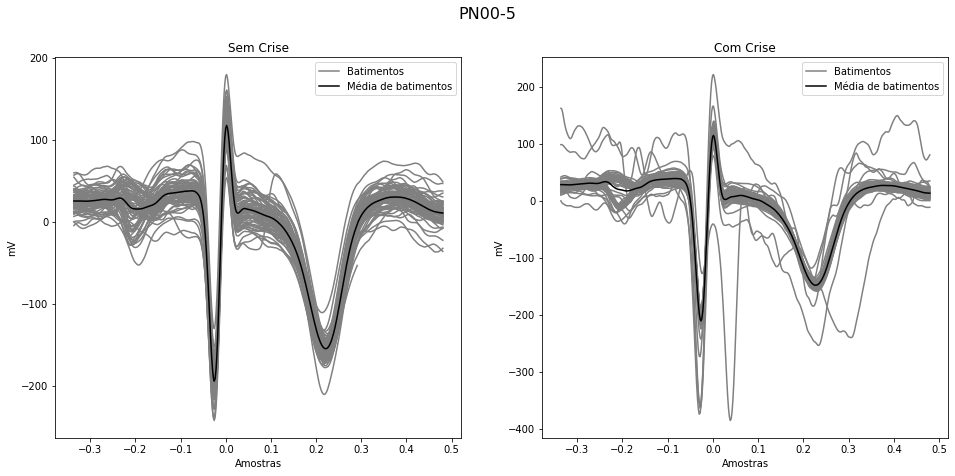

In [513]:
name = file.split('/')[-1].replace('.parquet', '')

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

beats_plot(axs[0], signals_sem, mean_signals_sem, 'Sem Crise')
beats_plot(axs[1], signals_com, mean_signals_com, 'Com Crise')

fig.suptitle(name, fontsize=16)



In [514]:
fig.savefig(f"{ROOT_PATH}reports/figures/batimentos/{name}.jpg")

## Salvando dados de Batimentos

In [515]:
def change_cols(df):
    cont = 1
    cols = []
    for col in df.columns:
        if col == 'Signal':
            col = f"Signal_{cont}"
        cols.append(col)
        cont+=1
    return cols


In [516]:
df1 = pd.concat(signals_com, axis=1)
df1['label'] = np.repeat('com_crise', len(df1))
df1 = df1.reset_index(drop=True)
df1.columns = change_cols(df1)



df2 = pd.concat(signals_sem, axis=1)
df2['label'] = np.repeat('sem_crise', len(df2))
df2 = df2.reset_index(drop=True)
df2.columns = change_cols(df2)



In [517]:
df1.to_parquet(f"{ROOT_PATH}data/processed/batimentos/com_crise/{name}.parquet")

df2.to_parquet(f"{ROOT_PATH}data/processed/batimentos/sem_crise/{name}.parquet")